In [26]:
# 필요한 라이브러리 설치
!pip install transformers datasets torch bertviz lit-nlp matplotlib seaborn pandas numpy
!pip install -U datasets
!pip install -U accelerate

# 기본 라이브러리 import
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    BertModel, 
    BertTokenizer,
    Trainer, 
    TrainingArguments,
    pipeline
)
from datasets import load_dataset, Dataset
from bertviz import model_view, head_view
import warnings
warnings.filterwarnings('ignore')

# 재현성을 위한 시드 설정
torch.manual_seed(42)
np.random.seed(42)

print("라이브러리 설치 및 import 완료")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
라이브러리 설치 및 import 완료
PyTorch version: 2.7.0+cpu
CUDA available: False


In [27]:
# IMDb 감정 분석 데이터셋 로딩
print("IMDb 데이터셋 로딩 중...")
dataset = load_dataset("imdb")

print("데이터셋 정보:")
print(dataset)
print(f"\n훈련 데이터 크기: {len(dataset['train'])}")
print(f"테스트 데이터 크기: {len(dataset['test'])}")

# 샘플 데이터 확인
print("\n샘플 데이터:")
for i in range(2):
    sample = dataset['train'][i]
    print(f"텍스트: {sample['text'][:100]}...")
    print(f"레이블: {sample['label']} ({'긍정' if sample['label'] == 1 else '부정'})")
    print("-" * 50)

# 작은 서브셋 생성 (GPU 미사용 환경에서의 빠른 실험을 위함)
small_train = dataset['train'].shuffle(seed=42).select(range(800))
small_test = dataset['test'].shuffle(seed=42).select(range(200))

print(f"\n서브셋 크기 - 훈련: {len(small_train)}, 테스트: {len(small_test)}")


IMDb 데이터셋 로딩 중...
데이터셋 정보:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

훈련 데이터 크기: 25000
테스트 데이터 크기: 25000

샘플 데이터:
텍스트: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
레이블: 0 (부정)
--------------------------------------------------
텍스트: "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's poli...
레이블: 0 (부정)
--------------------------------------------------

서브셋 크기 - 훈련: 800, 테스트: 200


In [28]:
# 모델과 토크나이저 초기화
model_name = "distilbert-base-uncased"
print(f"모델 로딩: {model_name}")

# 토크나이저 로딩
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 사전 학습된 BERT 모델 (attention 추출을 위해)
pretrained_bert = BertModel.from_pretrained(model_name, output_attentions=True)
pretrained_bert.eval()

# Fine-tuning을 위한 분류 모델
classification_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
    output_attentions=True
)

print("모델 로딩 완료")
print(f"모델 파라미터 수: {sum(p.numel() for p in classification_model.parameters()):,}")


모델 로딩: distilbert-base-uncased


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.inte

모델 로딩 완료
모델 파라미터 수: 66,955,010


In [29]:
def tokenize_function(examples):
    """텍스트 토큰화 함수"""
    return tokenizer(
        examples["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=512
    )

# 데이터셋 토큰화
print("데이터셋 토큰화 중...")
tokenized_train = small_train.map(tokenize_function, batched=True)
tokenized_test = small_test.map(tokenize_function, batched=True)

# 불필요한 컬럼 제거
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

# PyTorch 텐서 형태로 변환
tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

print("데이터 전처리 완료")


데이터셋 토큰화 중...


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

데이터 전처리 완료


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

# 훈련 인자 설정
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4, 
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="epoch",
    no_cuda=True  # CPU만 사용
)

# Trainer 초기화
trainer = Trainer(
    model=classification_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
)

print("Fine-tuning 시작...")
trainer.train()

print("Fine-tuning 완료!")

# Fine-tuned 모델 저장
trainer.save_model("./fine_tuned_bert")


In [36]:
# fine-tuned 모델 불러오기
from transformers import AutoModelForSequenceClassification

print("Fine-tuned 모델 로드 중...")
finetuned_model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_bert")

# trainer도 다시 생성
trainer = Trainer(
    model=finetuned_model,
    args=training_args,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer
)

# 모델 평가
print("모델 성능 평가...")
eval_results = trainer.evaluate()
print(f"Fine-tuned 모델 성능: {eval_results}")

# 간단한 예측 함수
def simple_predict(model, tokenizer, texts, labels):
    correct = 0
    total = len(texts)
    model.eval()

    with torch.no_grad():
        for text, true_label in zip(texts, labels):
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            outputs = model(**inputs)
            prediction = torch.argmax(outputs.logits, dim=-1).item()
            if prediction == true_label:
                correct += 1

    return correct / total

# 테스트 데이터 준비
test_texts = [small_test[i]['text'] for i in range(199)]
test_labels = [small_test[i]['label'] for i in range(199)]

# Fine-tuned 모델 정확도
finetuned_accuracy = simple_predict(finetuned_model, tokenizer, test_texts, test_labels)
print(f"Fine-tuned 모델 정확도: {finetuned_accuracy:.3f}")

# 사전 학습 모델 로드
pretrained_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

# Pretrained 모델 정확도
pretrained_accuracy = simple_predict(pretrained_model, tokenizer, test_texts, test_labels)
print(f"🔍 Pretrained 모델 정확도: {pretrained_accuracy:.3f}")


Fine-tuned 모델 로드 중...
모델 성능 평가...


Fine-tuned 모델 성능: {'eval_loss': 0.5669313669204712, 'eval_model_preparation_time': 0.001, 'eval_runtime': 42.9866, 'eval_samples_per_second': 4.653, 'eval_steps_per_second': 0.047}
Fine-tuned 모델 정확도: 0.829


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔍 Pretrained 모델 정확도: 0.492


In [4]:
def extract_attention(model, tokenizer, text, model_type="classification"):
    """
    모델에서 attention 가중치를 추출하는 함수
    
    Args:
        model: BERT 모델
        tokenizer: 토크나이저  
        text: 입력 텍스트
        model_type: "classification" 또는 "pretrained"
    
    Returns:
        attention weights, tokens
    """
    # 텍스트 토큰화
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    model.eval()
    with torch.no_grad():
        if model_type == "classification":
            outputs = model(**inputs, output_attentions=True)
        else:
            outputs = model(**inputs, output_attentions=True)
    
    # Attention 가중치 추출 (모든 레이어의 attention)
    attentions = outputs.attentions  # Tuple of attention weights for each layer
    
    return attentions, tokens, inputs

# 테스트 문장들 정의
test_sentences = [
    "This movie is absolutely fantastic! I loved every minute of it.",
    "The film was terrible and boring. I hated it.",
    "The movie was okay, nothing special but not bad either.",
]

print("Attention 추출 준비 완료")
print("테스트 문장들:")
for i, sentence in enumerate(test_sentences):
    print(f"{i+1}. {sentence}")


Attention 추출 준비 완료
테스트 문장들:
1. This movie is absolutely fantastic! I loved every minute of it.
2. The film was terrible and boring. I hated it.
3. The movie was okay, nothing special but not bad either.


In [20]:
from bertviz import head_view, model_view
from IPython.display import display, HTML

def visualize_attention_bertviz(model, tokenizer, text, model_name, model_type="classification"):
    """BertViz를 사용한 attention 시각화"""
    
    # 입력 준비
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    attention = outputs.attentions
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    print(f"\n=== {model_name} - Attention Visualization ===")
    print(f"텍스트: {text}")
    print(f"토큰 수: {len(tokens)}")
    
    # Head View (마지막 레이어의 모든 헤드)
    try:
        print(f"\n{model_name} - Head View (Layer 11):")
        head_view(attention, tokens, layer=5, heads=list(range(12)))
    except Exception as e:
        print(f"Head view 시각화 중 오류: {e}")
    
    # Model View (모든 레이어와 헤드의 개요)
    try:
        print(f"\n{model_name} - Model View:")
        model_view(attention, tokens)
    except Exception as e:
        print(f"Model view 시각화 중 오류: {e}")

# 사전 학습된 모델과 fine-tuned 모델 비교
test_sentence = test_sentences[0]  # 긍정적인 문장

print("=== BERT Attention 시각화 비교 ===")

# 1. 사전 학습된 BERT
print("\n1. 사전 학습된 BERT 모델")
visualize_attention_bertviz(pretrained_bert, tokenizer, test_sentence, "Pretrained BERT", "pretrained")

# 2. Fine-tuned BERT  
print("\n2. Fine-tuned BERT 모델")
visualize_attention_bertviz(classification_model, tokenizer, test_sentence, "Fine-tuned BERT", "classification")


=== BERT Attention 시각화 비교 ===

1. 사전 학습된 BERT 모델

=== Pretrained BERT - Attention Visualization ===
텍스트: This movie is absolutely fantastic! I loved every minute of it.
토큰 수: 15

Pretrained BERT - Head View (Layer 11):


<IPython.core.display.Javascript object>


Pretrained BERT - Model View:


<IPython.core.display.Javascript object>


2. Fine-tuned BERT 모델

=== Fine-tuned BERT - Attention Visualization ===
텍스트: This movie is absolutely fantastic! I loved every minute of it.
토큰 수: 15

Fine-tuned BERT - Head View (Layer 11):


<IPython.core.display.Javascript object>


Fine-tuned BERT - Model View:


<IPython.core.display.Javascript object>

In [124]:
def analyze_attention_weights(attentions, tokens, target_words=None):
    """
    Attention 가중치 수치 분석 ('.' 와 'SEP' 토큰 제외 후 계산)
    
    Args:
        attentions: attention weights tuple
        tokens: tokenized words
        target_words: 관심 있는 단어들 (감정 관련 단어)
    
    Returns:
        분석 결과 딕셔너리
    """
    if target_words is None:
        target_words = ['great', 'amazing', 'fantastic', 'wonderful', 'excellent', 'terrible',
                        'awful', 'horrible', 'bad', 'hate', 'hated', 'loved', 'boring' ]
    
    last_layer_attention = attentions[-1][0]  # [num_heads, seq_len, seq_len]
    avg_attention = last_layer_attention.mean(dim=0)  # [seq_len, seq_len]
    
    # 제외할 토큰 인덱스 찾기
    exclude_tokens = ['.', 'SEP']
    exclude_indices = [i for i, t in enumerate(tokens) if t in exclude_tokens]
    
    # 전체 토큰 수 (제외 토큰 제외)
    valid_indices = [i for i in range(len(tokens)) if i not in exclude_indices]
    num_valid_tokens = len(valid_indices)
    
    results = {
        'tokens': tokens,
        'avg_attention': avg_attention.numpy(),
        'target_word_attention': {}
    }
    
    for i, token in enumerate(tokens):
        token_clean = token.replace('##', '').lower()
        if token_clean in target_words:
            # incoming_attention: 다른 토큰들 중 '.' 와 'SEP' 제외한 토큰들로부터 받는 attention 평균
            incoming_sum = 0.0
            for idx in valid_indices:
                incoming_sum += avg_attention[idx, i].item()
            incoming_attention = incoming_sum / num_valid_tokens if num_valid_tokens > 0 else 0
            
            # outgoing_attention: 이 토큰이 '.' 와 'SEP' 제외한 다른 토큰들에게 주는 attention 평균
            outgoing_sum = 0.0
            for idx in valid_indices:
                outgoing_sum += avg_attention[i, idx].item()
            outgoing_attention = outgoing_sum / num_valid_tokens if num_valid_tokens > 0 else 0
            
            results['target_word_attention'][token] = {
                'incoming': incoming_attention,
                'outgoing': outgoing_attention,
                'position': i
            }
    
    return results


# 각 테스트 문장에 대해 두 모델의 attention 분석
comparison_results = []

for sentence in test_sentences:
    print(f"\n분석 문장: {sentence}")
    print("=" * 80)
    
    # 사전 학습된 모델 attention 추출
    pretrained_attentions, pretrained_tokens, _ = extract_attention(
        pretrained_bert, tokenizer, sentence, "pretrained"
    )
    
    # Fine-tuned 모델 attention 추출  
    finetuned_attentions, finetuned_tokens, _ = extract_attention(
        classification_model, tokenizer, sentence, "classification"
    )
    
    # Attention 분석
    pretrained_analysis = analyze_attention_weights(pretrained_attentions, pretrained_tokens)
    finetuned_analysis = analyze_attention_weights(finetuned_attentions, finetuned_tokens)
    
    # 결과 비교
    print("\n타겟 단어들의 Attention 변화:")
    print(f"{'단어':<15} {'Pre-trained':<20} {'Fine-tuned':<20} {'변화량':<15}")
    print("-" * 75)
    
    for token in pretrained_analysis['target_word_attention']:
        if token in finetuned_analysis['target_word_attention']:
            pre_incoming = pretrained_analysis['target_word_attention'][token]['incoming']
            fine_incoming = finetuned_analysis['target_word_attention'][token]['incoming']
            change = fine_incoming - pre_incoming
            
            print(f"{token:<15} {pre_incoming:<20.4f} {fine_incoming:<20.4f} {change:<15.4f}")
    
    comparison_results.append({
        'sentence': sentence,
        'pretrained': pretrained_analysis,
        'finetuned': finetuned_analysis
    })



분석 문장: This movie is absolutely fantastic! I loved every minute of it.

타겟 단어들의 Attention 변화:
단어              Pre-trained          Fine-tuned           변화량            
---------------------------------------------------------------------------
fantastic       0.0609               0.0197               -0.0412        
loved           0.0703               0.0301               -0.0403        

분석 문장: The film was terrible and boring. I hated it.

타겟 단어들의 Attention 변화:
단어              Pre-trained          Fine-tuned           변화량            
---------------------------------------------------------------------------
terrible        0.0773               0.0315               -0.0458        
boring          0.0797               0.0292               -0.0505        
hated           0.0754               0.0402               -0.0352        

분석 문장: The movie was okay, nothing special but not bad either.

타겟 단어들의 Attention 변화:
단어              Pre-trained          Fine-tuned           변화량          


==================== 문장 1 Attention 비교 ====================
문장: This movie is absolutely fantastic! I loved every minute of it.


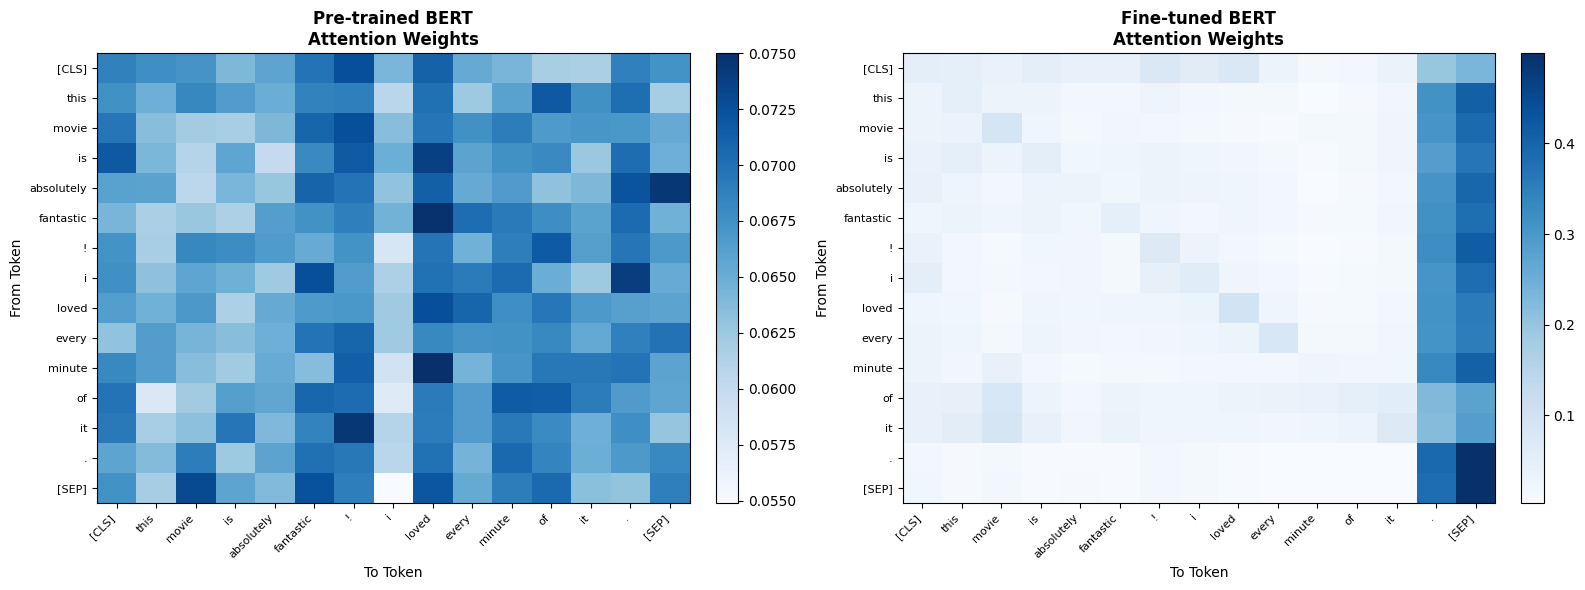


주요 관찰사항:
- 감정 관련 단어 발견: ['fantastic', 'loved']
  * 'fantastic': Fine-tuning 후 attention 감소 (0.069 → 0.022)
  * 'loved': Fine-tuning 후 attention 감소 (0.071 → 0.028)

==================== 문장 2 Attention 비교 ====================
문장: The film was terrible and boring. I hated it.


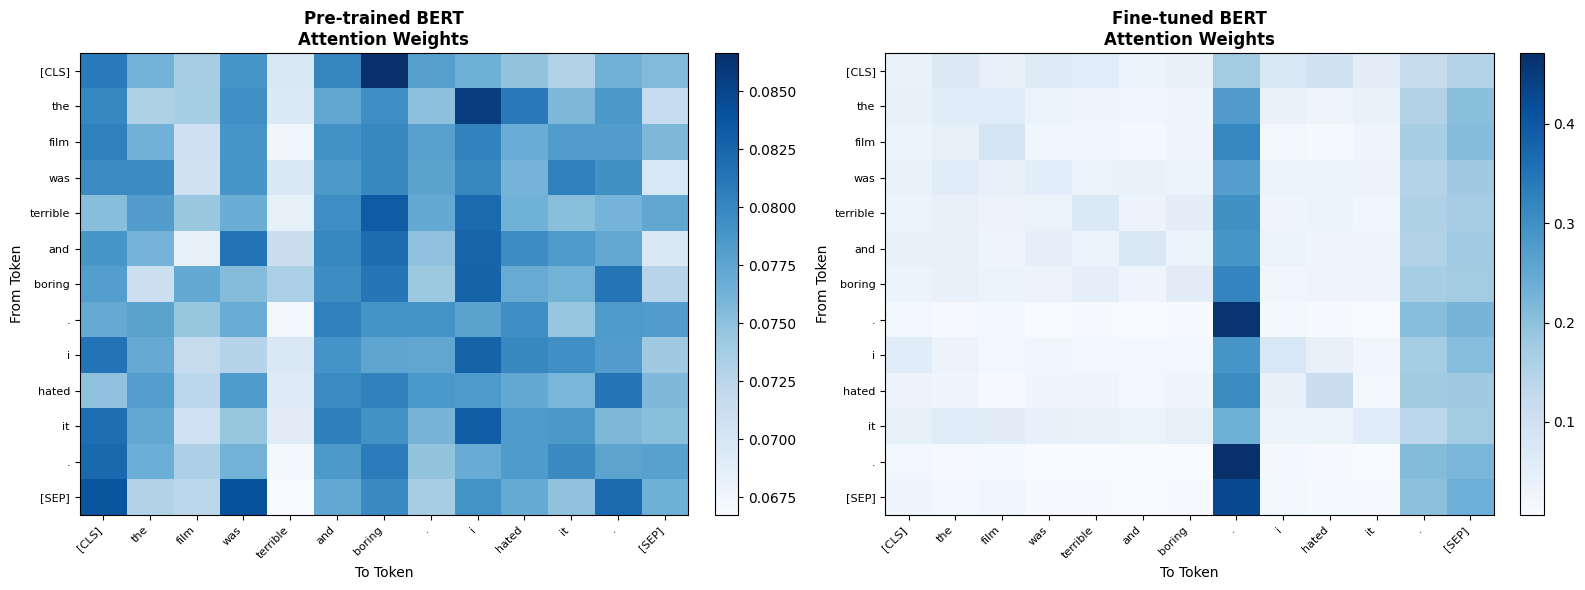


주요 관찰사항:
- 감정 관련 단어 발견: ['terrible', 'boring']
  * 'terrible': Fine-tuning 후 attention 감소 (0.069 → 0.031)
  * 'boring': Fine-tuning 후 attention 감소 (0.081 → 0.029)

==================== 문장 3 Attention 비교 ====================
문장: The movie was okay, nothing special but not bad either.


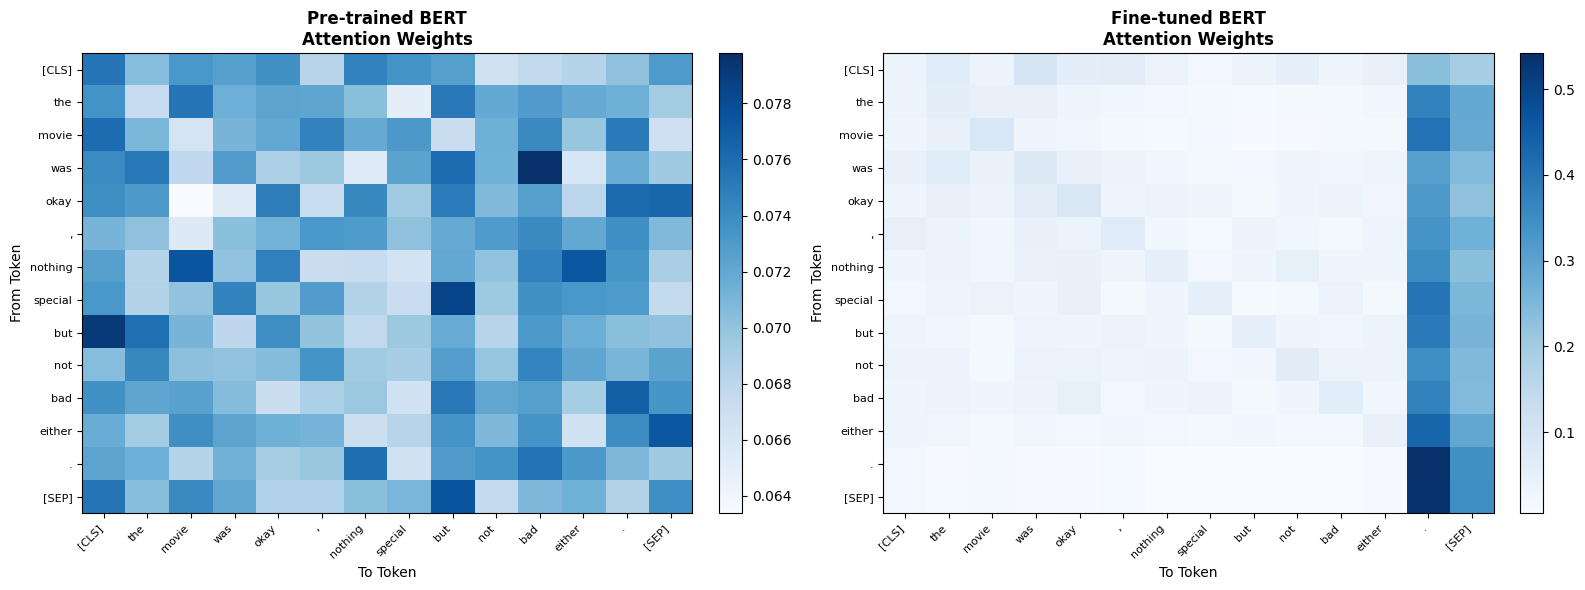


주요 관찰사항:
- 감정 관련 단어 발견: ['bad']
  * 'bad': Fine-tuning 후 attention 감소 (0.074 → 0.026)


In [16]:
def plot_attention_heatmap(attention_weights, tokens, title, ax):
    """
    Attention 가중치 히트맵 시각화
    
    Args:
        attention_weights: 평균 attention 가중치 [seq_len, seq_len]
        tokens: 토큰 리스트
        title: 그래프 제목
        ax: matplotlib axis
    """
    # 토큰이 너무 많으면 일부만 표시
    max_tokens = 20
    if len(tokens) > max_tokens:
        attention_weights = attention_weights[:max_tokens, :max_tokens]
        tokens = tokens[:max_tokens]
    
    # 히트맵 그리기
    im = ax.imshow(attention_weights, cmap='Blues', aspect='auto')
    
    # 축 설정
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(tokens, fontsize=8)
    
    ax.set_xlabel('To Token')
    ax.set_ylabel('From Token')
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    # 컬러바 추가
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    return im

# 각 테스트 문장에 대해 side-by-side 비교 시각화
for i, result in enumerate(comparison_results):
    sentence = result['sentence']
    pretrained_analysis = result['pretrained']
    finetuned_analysis = result['finetuned']
    
    print(f"\n{'='*20} 문장 {i+1} Attention 비교 {'='*20}")
    print(f"문장: {sentence}")
    
    # 그래프 설정
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 사전 학습된 모델 히트맵
    plot_attention_heatmap(
        pretrained_analysis['avg_attention'], 
        pretrained_analysis['tokens'],
        'Pre-trained BERT\nAttention Weights', 
        ax1
    )
    
    # Fine-tuned 모델 히트맵
    plot_attention_heatmap(
        finetuned_analysis['avg_attention'], 
        finetuned_analysis['tokens'],
        'Fine-tuned BERT\nAttention Weights', 
        ax2
    )
    
    plt.tight_layout()
    plt.show()
    
    # 주요 차이점 분석
    print(f"\n주요 관찰사항:")
    
    # 감정 단어에 대한 attention 변화 요약
    emotion_words_found = []
    for token in pretrained_analysis['target_word_attention']:
        if token in finetuned_analysis['target_word_attention']:
            emotion_words_found.append(token)
    
    if emotion_words_found:
        print(f"- 감정 관련 단어 발견: {emotion_words_found}")
        for word in emotion_words_found:
            pre_att = pretrained_analysis['target_word_attention'][word]['incoming']
            fine_att = finetuned_analysis['target_word_attention'][word]['incoming']
            if fine_att > pre_att:
                print(f"  * '{word}': Fine-tuning 후 attention 증가 ({pre_att:.3f} → {fine_att:.3f})")
            else:
                print(f"  * '{word}': Fine-tuning 후 attention 감소 ({pre_att:.3f} → {fine_att:.3f})")
    else:
        print("- 명시적인 감정 단어는 발견되지 않았으나, 전체적인 attention 패턴의 변화를 관찰할 수 있음")



==================== 문장 1 Attention 비교 ====================
문장: This movie is absolutely fantastic! I loved every minute of it.


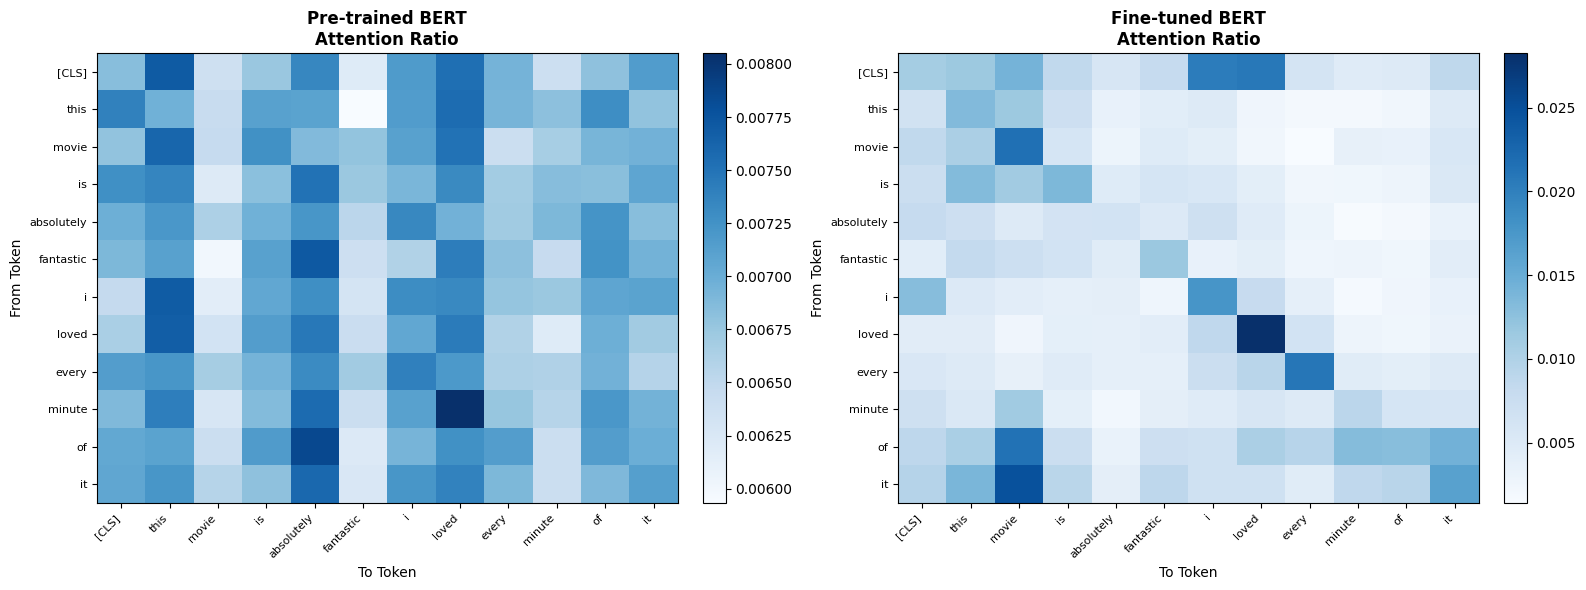


주요 관찰사항:
- 감정 관련 단어 (특수 토큰 제외): ['fantastic', 'loved']
  * 'fantastic': 0.4640 → 0.3963 (attention 비율 감소 -14.6%)
  * 'loved': 0.5360 → 0.6037 (attention 비율 증가 +12.63945%)

==================== 문장 2 Attention 비교 ====================
문장: The film was terrible and boring. I hated it.


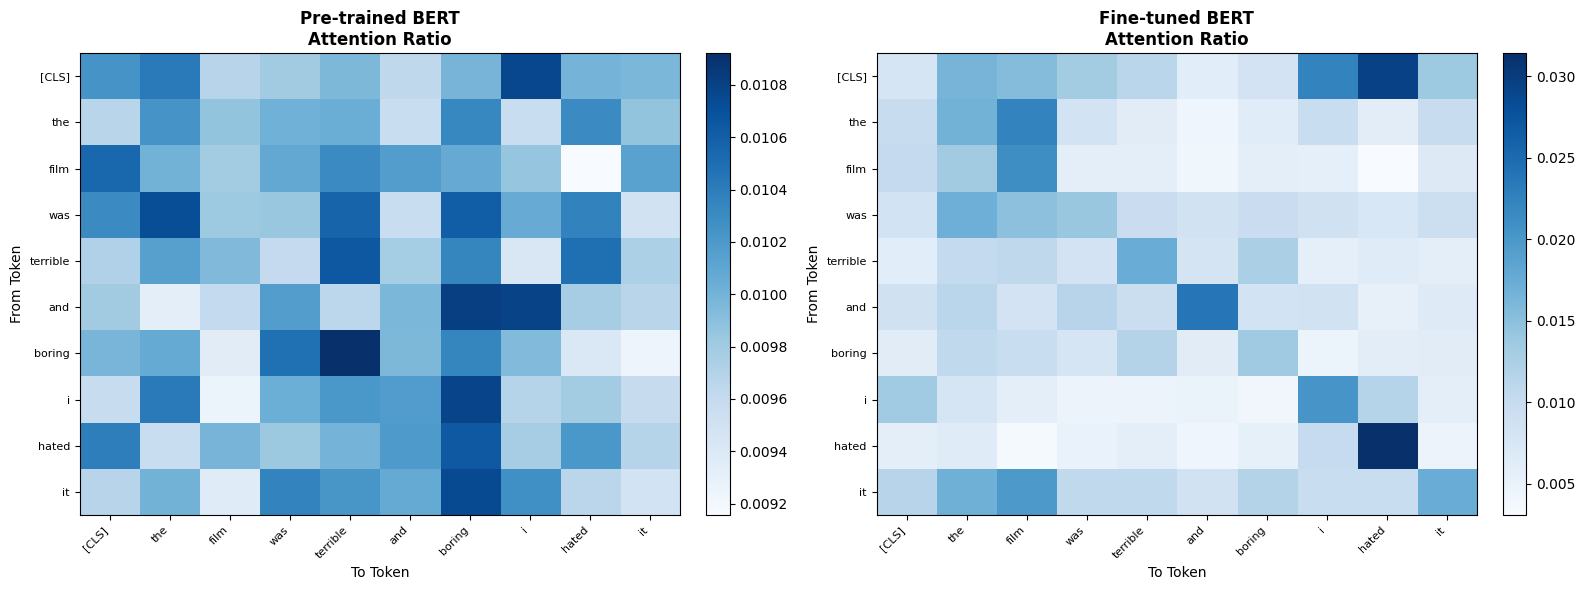


주요 관찰사항:
- 감정 관련 단어 (특수 토큰 제외): ['boring', 'hated', 'terrible']
  * 'boring': 0.3429 → 0.2896 (attention 비율 감소 -15.6%)
  * 'hated': 0.3244 → 0.3980 (attention 비율 증가 +22.71451%)
  * 'terrible': 0.3327 → 0.3124 (attention 비율 감소 -6.1%)

==================== 문장 3 Attention 비교 ====================
문장: The movie was okay, nothing special but not bad either.


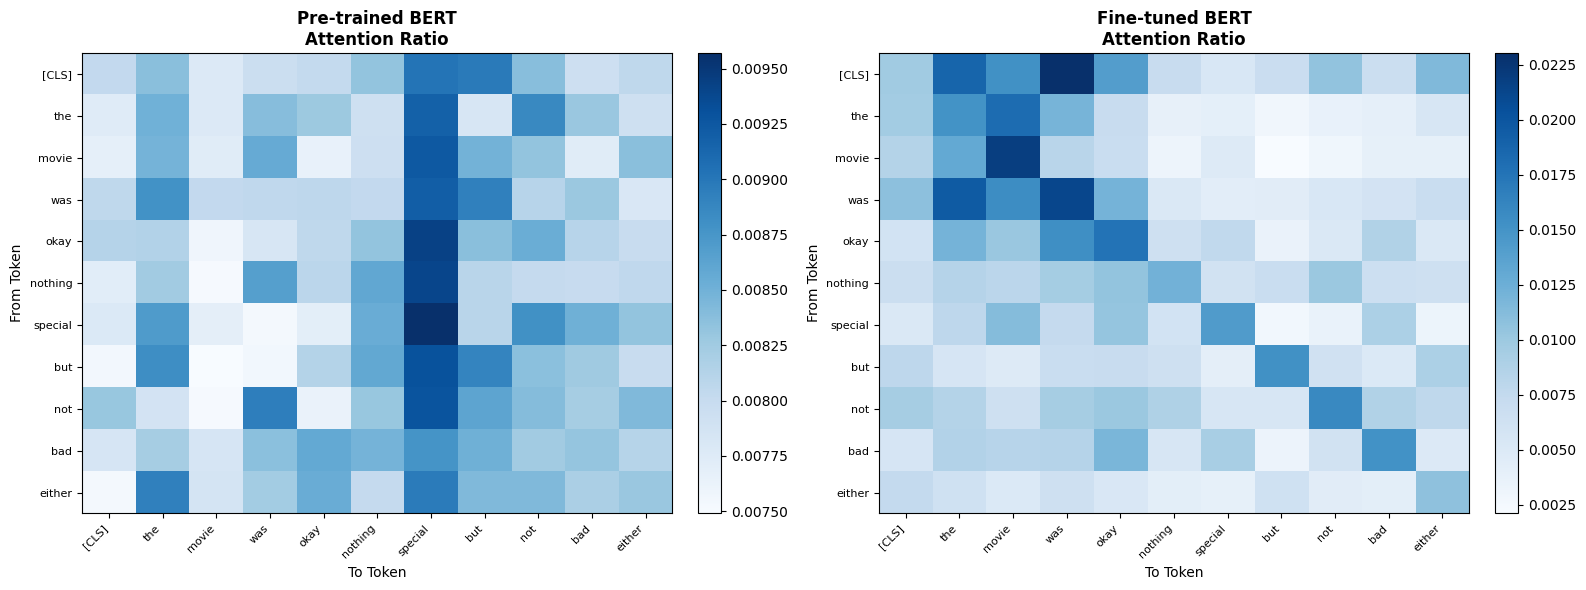


주요 관찰사항:
- 감정 관련 단어 (특수 토큰 제외): ['bad']
  * 'bad': 1.0000 → 1.0000 (attention 비율 증가 +0.00000%)


In [90]:
EXCLUDE_TOKENS = {'.', '[SEP]', ',', ';', '!', '?'}

def get_valid_token_indices(tokens):
    """특수 토큰 제외한 인덱스 리스트 반환"""
    return [i for i, t in enumerate(tokens) if t not in EXCLUDE_TOKENS]

def normalize_attention_to_ratio(attention, tokens):
    """
    attention: [seq_len, seq_len] numpy 배열 혹은 tensor
    tokens: 토큰 리스트
    
    특수 토큰 제외 후, 남은 토큰들의 attention 값만 남기고 전체 attention 총합으로 나누어 비율 계산
    """
    valid_indices = get_valid_token_indices(tokens)
    
    # attention 서브셋 (valid tokens만)
    att_sub = attention[np.ix_(valid_indices, valid_indices)]
    
    # 전체 합
    total_sum = att_sub.sum()
    if total_sum == 0:
        return att_sub  # 0인 경우는 그대로 리턴
    
    att_ratio = att_sub / total_sum
    return att_ratio, [tokens[i] for i in valid_indices]

def plot_attention_heatmap(attention_weights, tokens, title, ax):
    """
    Attention 비율 기반 히트맵 그리기
    """
    max_tokens = 20
    if len(tokens) > max_tokens:
        attention_weights = attention_weights[:max_tokens, :max_tokens]
        tokens = tokens[:max_tokens]
    
    im = ax.imshow(attention_weights, cmap='Blues', aspect='auto')
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(tokens, fontsize=8)
    ax.set_xlabel('To Token')
    ax.set_ylabel('From Token')
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    return im

# 각 문장에 대해 시각화
for i, result in enumerate(comparison_results):
    sentence = result['sentence']
    pretrained_analysis = result['pretrained']
    finetuned_analysis = result['finetuned']
    
    print(f"\n{'='*20} 문장 {i+1} Attention 비교 {'='*20}")
    print(f"문장: {sentence}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 비율로 변환
    pre_attention_ratio, pre_tokens_filtered = normalize_attention_to_ratio(pretrained_analysis['avg_attention'], pretrained_analysis['tokens'])
    fine_attention_ratio, fine_tokens_filtered = normalize_attention_to_ratio(finetuned_analysis['avg_attention'], finetuned_analysis['tokens'])
    
    plot_attention_heatmap(pre_attention_ratio, pre_tokens_filtered, 'Pre-trained BERT\nAttention Ratio', ax1)
    plot_attention_heatmap(fine_attention_ratio, fine_tokens_filtered, 'Fine-tuned BERT\nAttention Ratio', ax2)
    
    plt.tight_layout()
    plt.show()
    
    # 감정 단어에 대한 비율 증감 출력
    print("\n주요 관찰사항:")
    pre_ratios = compute_attention_ratios(pretrained_analysis['target_word_attention'])
    fine_ratios = compute_attention_ratios(finetuned_analysis['target_word_attention'])
    
    common_tokens = set(pre_ratios.keys()) & set(fine_ratios.keys())
    if not common_tokens:
        print("- 분석 가능한 감정 관련 토큰이 없음")
        continue
    
    print(f"- 감정 관련 단어 (특수 토큰 제외): {sorted(common_tokens)}")
    for token in sorted(common_tokens):
        pre_ratio = pre_ratios[token]
        fine_ratio = fine_ratios[token]
        if pre_ratio == 0:
            change_str = "기존 attention이 0 → 변화율 계산 불가"
        else:
            change_pct = (fine_ratio - pre_ratio) / pre_ratio * 100
            if change_pct >= 0:
                change_str = f"attention 비율 증가 +{change_pct:.5f}%"
            else:
                change_str = f"attention 비율 감소 {change_pct:.1f}%"
        print(f"  * '{token}': {pre_ratio:.4f} → {fine_ratio:.4f} ({change_str})")


In [110]:
EXCLUDE_TOKENS = {'.', ',', '[SEP]'}

def analyze_token_pair_attention(result, token1_idx, token2_idx):
    """
    특정 토큰 쌍 간의 attention 변화 분석 (비율 기준, '.'과 '[SEP]' 제외)
    """
    pretrained_attention = result['pretrained']['avg_attention']
    finetuned_attention = result['finetuned']['avg_attention']
    tokens = result['pretrained']['tokens']
    
    # 제외 토큰이 포함된 인덱스면 분석 안 함
    if tokens[token1_idx] in EXCLUDE_TOKENS or tokens[token2_idx] in EXCLUDE_TOKENS:
        return None
    
    # 전체 attention 합은 token1_idx row에서 제외 토큰을 제외하고 계산
    def total_attention_excluding_tokens(att_matrix, tokens, row_idx):
        valid_indices = [i for i, t in enumerate(tokens) if t not in EXCLUDE_TOKENS]
        total = sum(att_matrix[row_idx, i] for i in valid_indices)
        return total
    
    if token1_idx < len(tokens) and token2_idx < len(tokens):
        pre_total = total_attention_excluding_tokens(pretrained_attention, tokens, token1_idx)
        fine_total = total_attention_excluding_tokens(finetuned_attention, tokens, token1_idx)
        
        # 0 나누기 방지
        if pre_total == 0 or fine_total == 0:
            return None
        
        pre_ratio = pretrained_attention[token1_idx, token2_idx] / pre_total
        fine_ratio = finetuned_attention[token1_idx, token2_idx] / fine_total
        change = fine_ratio - pre_ratio
        
        print(f"토큰 쌍 분석: '{tokens[token1_idx]}' → '{tokens[token2_idx]}'")
        print(f"  Pre-trained 비율: {pre_ratio:.4%}")
        print(f"  Fine-tuned 비율: {fine_ratio:.4%}")
        print(f"  변화량: {change:+.4%}p ({'증가' if change > 0 else '감소'})")
        
        return {
            'token1': tokens[token1_idx],
            'token2': tokens[token2_idx],
            'pre_ratio': pre_ratio,
            'fine_ratio': fine_ratio,
            'change': change
        }
    return None

print("\n=== 토큰 쌍 Attention 변화 분석 (비율 기반, '.'과 '[SEP]' 제외) ===")

for i, result in enumerate(comparison_results):
    print(f"\n문장 {i+1}: {result['sentence']}")
    print("-" * 60)
    
    tokens = result['pretrained']['tokens']
    
    cls_attention_changes = []
    for j in range(1, min(len(tokens), 20)):
        analysis = analyze_token_pair_attention(result, 0, j)
        if analysis:
            cls_attention_changes.append(analysis)
    
    if cls_attention_changes:
        # 증가한 것 중 변화량 절대값 최대
        increases = [x for x in cls_attention_changes if x['change'] > 0]
        if increases:
            max_increase = max(increases, key=lambda x: x['change'])
            print(f"\n[CLS] 토큰에서 가장 큰 attention 비율 증가:")
            print(f"  {max_increase['token1']} → {max_increase['token2']}")
            print(f"  변화량: +{max_increase['change']:.4%}")
        
        # 감소한 것 중 변화량 절대값 최대
        decreases = [x for x in cls_attention_changes if x['change'] < 0]
        if decreases:
            max_decrease = min(decreases, key=lambda x: x['change'])  # 음수 중 가장 작은 값 (절대값 최대)
            print(f"\n[CLS] 토큰에서 가장 큰 attention 비율 감소:")
            print(f"  {max_decrease['token1']} → {max_decrease['token2']}")
            print(f"  변화량: {max_decrease['change']:.4%}")




=== 토큰 쌍 Attention 변화 분석 (비율 기반, '.'과 '[SEP]' 제외) ===

문장 1: This movie is absolutely fantastic! I loved every minute of it.
------------------------------------------------------------
토큰 쌍 분석: '[CLS]' → 'this'
  Pre-trained 비율: 8.5142%
  Fine-tuned 비율: 7.8586%
  변화량: -0.6555%p (감소)
토큰 쌍 분석: '[CLS]' → 'movie'
  Pre-trained 비율: 7.0473%
  Fine-tuned 비율: 9.5975%
  변화량: +2.5502%p (증가)
토큰 쌍 분석: '[CLS]' → 'is'
  Pre-trained 비율: 7.4605%
  Fine-tuned 비율: 5.7518%
  변화량: -1.7087%p (감소)
토큰 쌍 분석: '[CLS]' → 'absolutely'
  Pre-trained 비율: 8.1205%
  Fine-tuned 비율: 3.8837%
  변화량: -4.2368%p (감소)
토큰 쌍 분석: '[CLS]' → 'fantastic'
  Pre-trained 비율: 6.8464%
  Fine-tuned 비율: 5.4568%
  변화량: -1.3896%p (감소)
토큰 쌍 분석: '[CLS]' → '!'
  Pre-trained 비율: 8.0007%
  Fine-tuned 비율: 15.6342%
  변화량: +7.6334%p (증가)
토큰 쌍 분석: '[CLS]' → 'i'
  Pre-trained 비율: 7.9272%
  Fine-tuned 비율: 13.7864%
  변화량: +5.8592%p (증가)
토큰 쌍 분석: '[CLS]' → 'loved'
  Pre-trained 비율: 8.3299%
  Fine-tuned 비율: 14.1251%
  변화량: +5.7951%p (증가)
토큰 쌍 분석: '[CL


=== Overall Attention Pattern Change Analysis ===


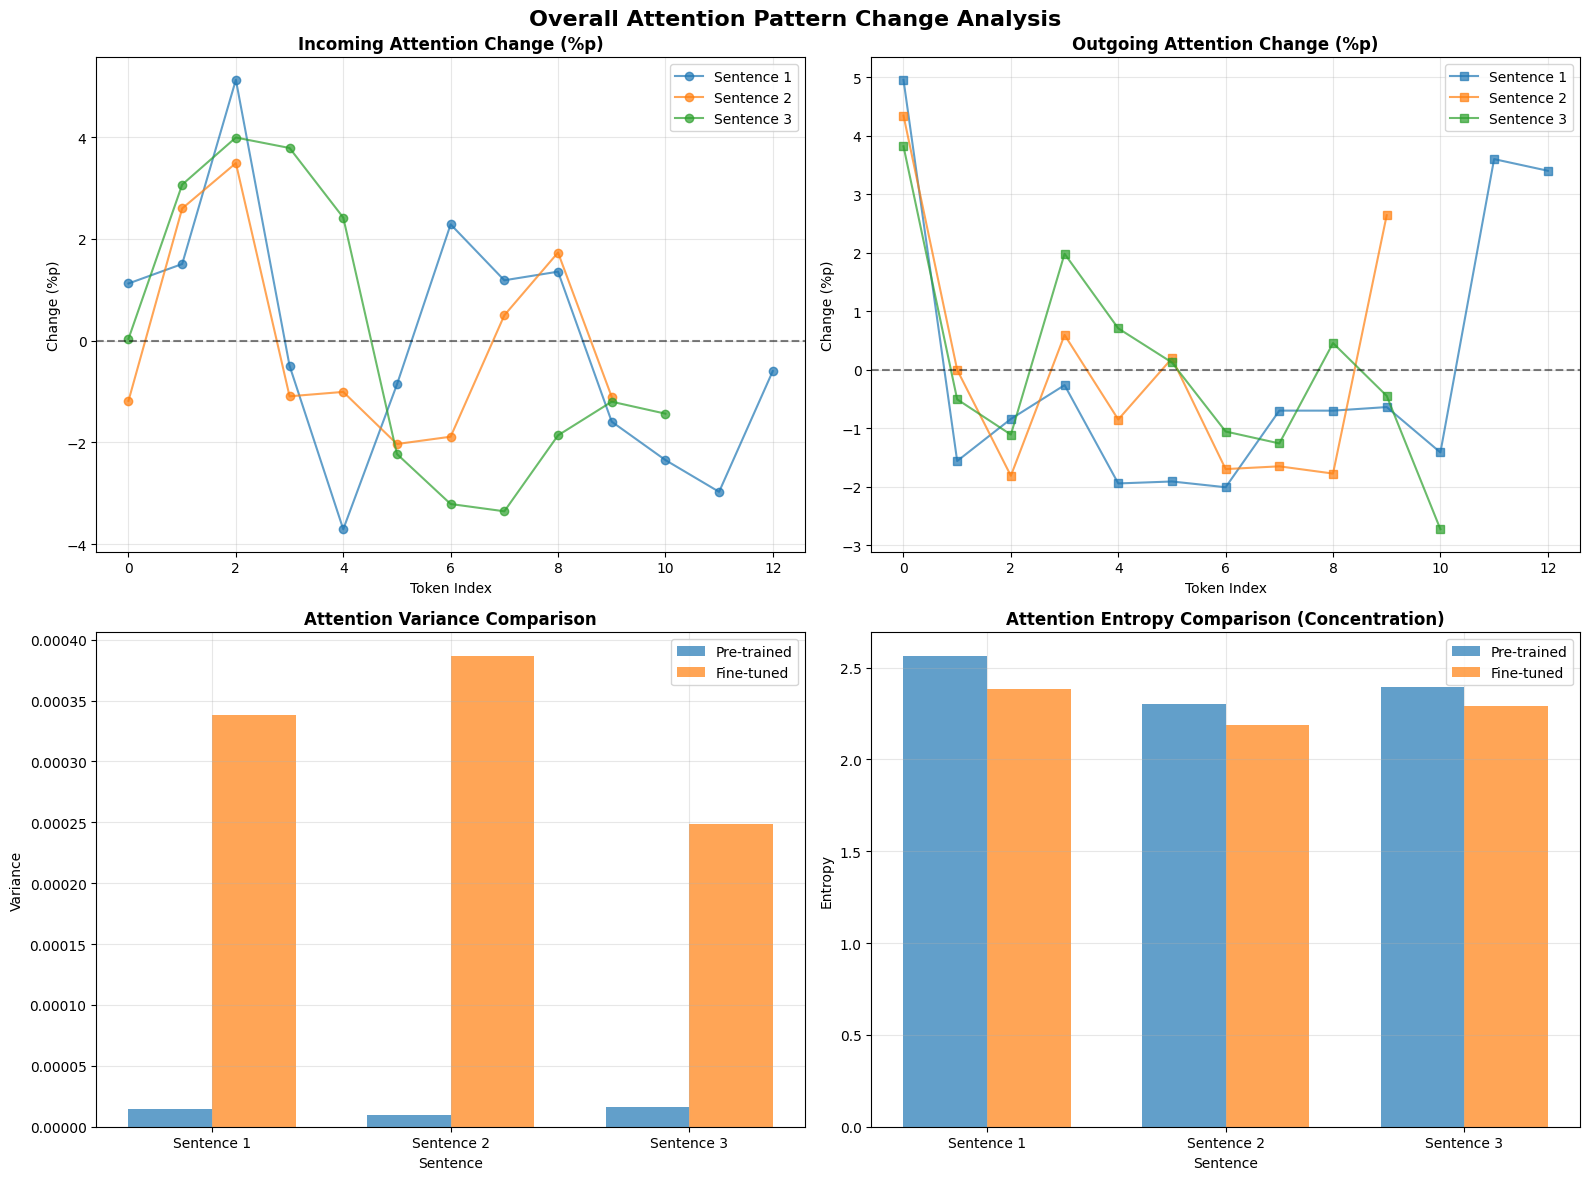


=== Attention Change Analysis for All Emotion Expression Words ===


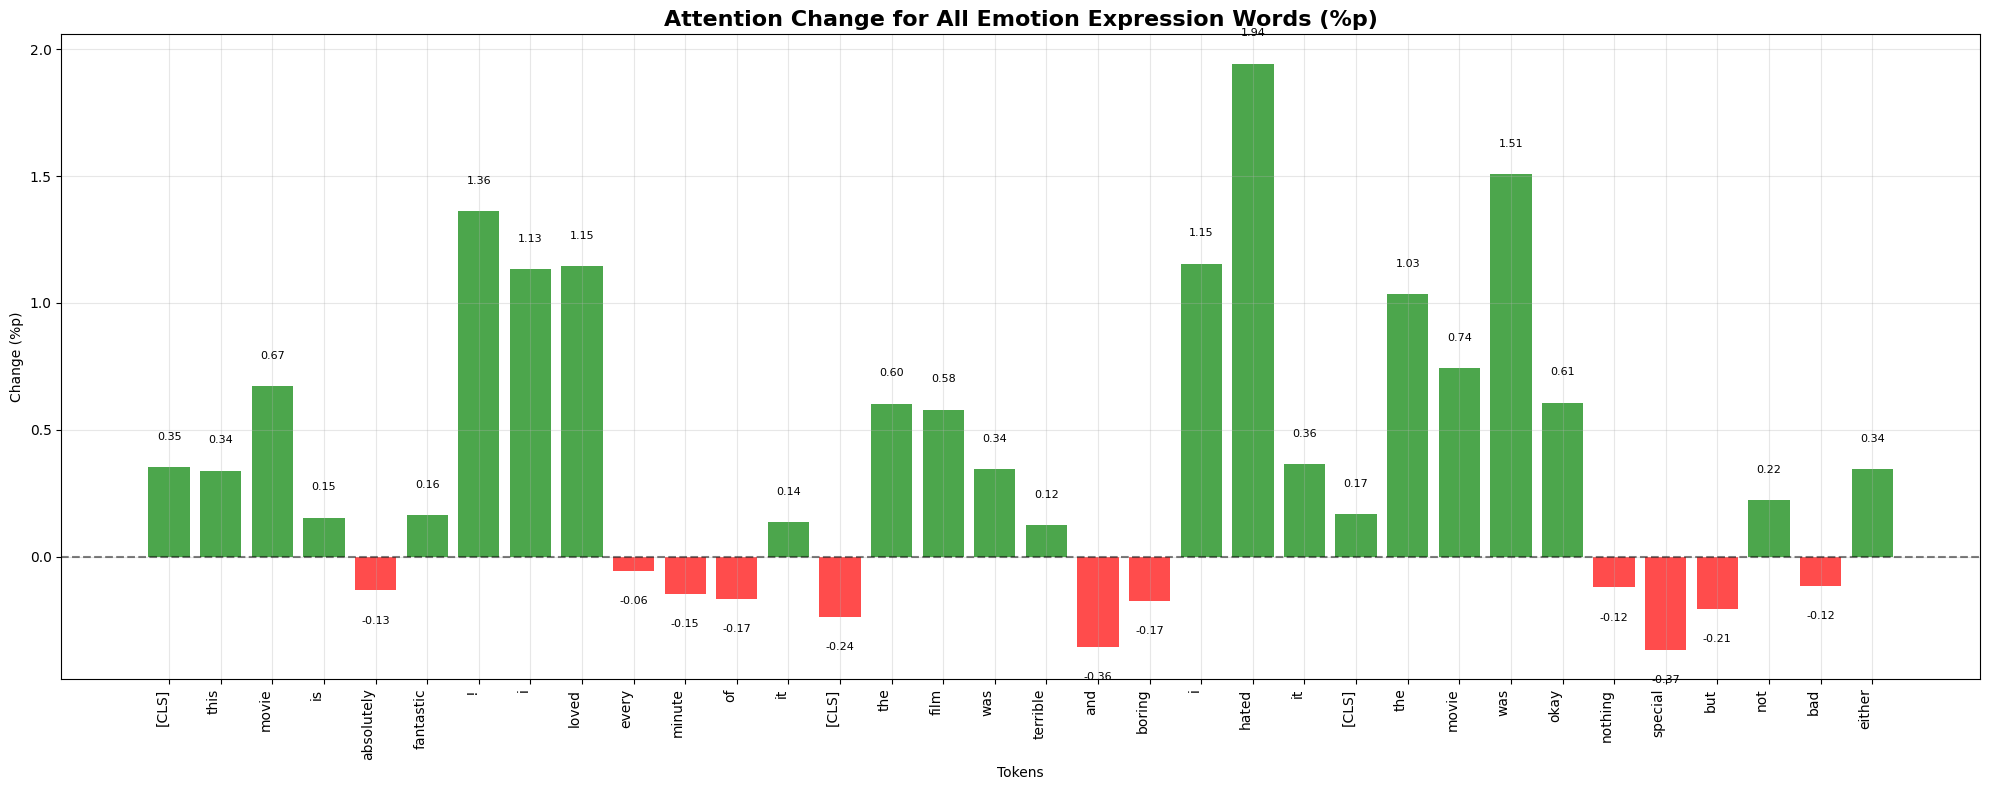

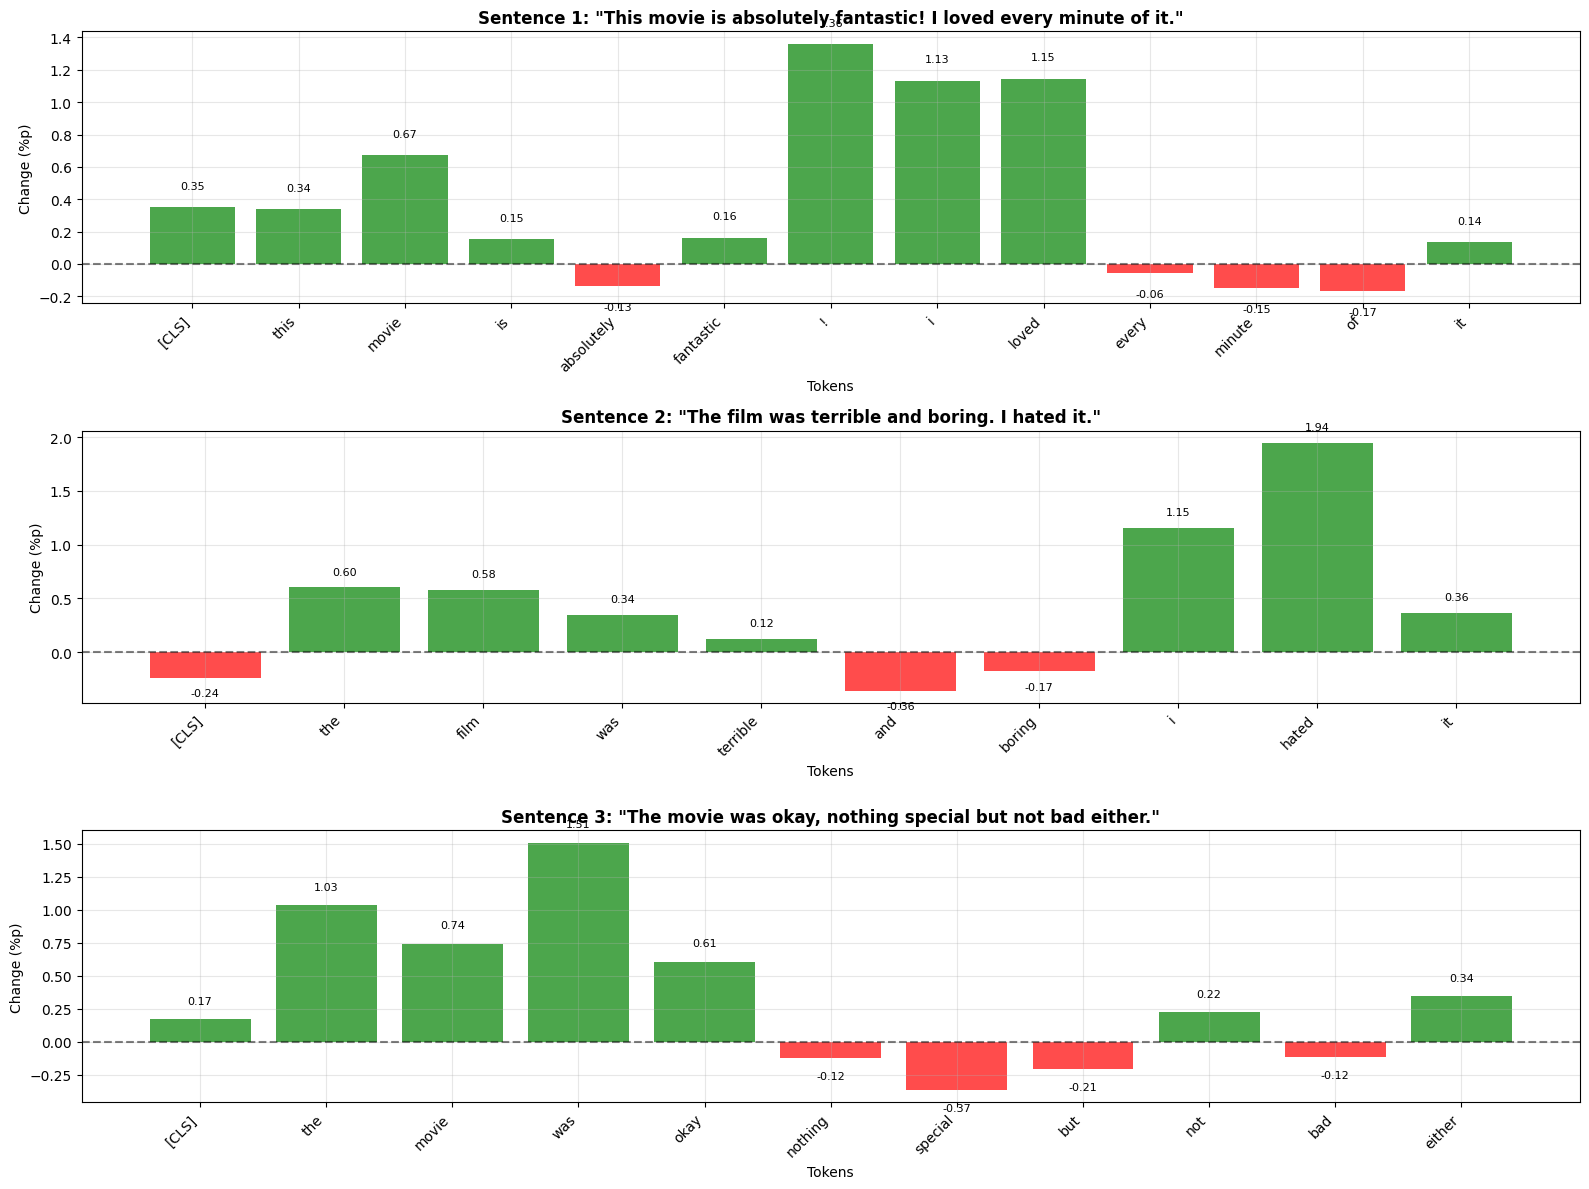


Detailed Attention Changes for Emotion Expression Words:
--------------------------------------------------------------------------------
Sentence 1: 'This movie is absolutely fantastic! I loved every minute of it.'
  Token: '[CLS]'
  Pre-trained: 0.0058
  Fine-tuned: 0.0093
  Change: +0.35%p

Sentence 1: 'This movie is absolutely fantastic! I loved every minute of it.'
  Token: 'this'
  Pre-trained: 0.0065
  Fine-tuned: 0.0099
  Change: +0.34%p

Sentence 1: 'This movie is absolutely fantastic! I loved every minute of it.'
  Token: 'movie'
  Pre-trained: 0.0054
  Fine-tuned: 0.0121
  Change: +0.67%p

Sentence 1: 'This movie is absolutely fantastic! I loved every minute of it.'
  Token: 'is'
  Pre-trained: 0.0057
  Fine-tuned: 0.0073
  Change: +0.15%p

Sentence 1: 'This movie is absolutely fantastic! I loved every minute of it.'
  Token: 'absolutely'
  Pre-trained: 0.0062
  Fine-tuned: 0.0049
  Change: -0.13%p

Sentence 1: 'This movie is absolutely fantastic! I loved every minute of it

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Define emotion words (can be extended as needed)
EMOTION_WORDS = {
    'positive': ['good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic', 'love', 'like', 'happy', 'joy'],
    'negative': ['bad', 'terrible', 'awful', 'hate', 'sad', 'angry', 'disappointed', 'horrible', 'worst', 'disgusting']
}

def is_emotion_word(token):
    """Check if token is an emotion word"""
    token_lower = token.lower()
    for emotion_type, words in EMOTION_WORDS.items():
        if token_lower in words:
            return True, emotion_type
    return False, None

def calculate_overall_attention_distribution(attention_matrix, tokens):
    """Calculate overall attention distribution excluding special tokens"""
    valid_indices = get_valid_token_indices(tokens)
    
    # Total attention each token receives (column sum)
    incoming_attention = np.zeros(len(valid_indices))
    # Total attention each token gives (row sum)
    outgoing_attention = np.zeros(len(valid_indices))
    
    for i, valid_i in enumerate(valid_indices):
        for j, valid_j in enumerate(valid_indices):
            incoming_attention[i] += attention_matrix[valid_j, valid_i]
            outgoing_attention[i] += attention_matrix[valid_i, valid_j]
    
    # Normalize
    total_incoming = incoming_attention.sum()
    total_outgoing = outgoing_attention.sum()
    
    if total_incoming > 0:
        incoming_attention = incoming_attention / total_incoming
    if total_outgoing > 0:
        outgoing_attention = outgoing_attention / total_outgoing
    
    return incoming_attention, outgoing_attention, [tokens[i] for i in valid_indices]

def extract_all_token_attention_changes(comparison_results):
    """Extract attention changes for all tokens (treating all as emotion expression words)"""
    all_changes = []
    
    for i, result in enumerate(comparison_results):
        sentence = result['sentence']
        pre_attention = result['pretrained']['avg_attention']
        fine_attention = result['finetuned']['avg_attention']
        tokens = result['pretrained']['tokens']
        
        # Calculate normalized attention
        pre_ratio, pre_tokens = normalize_attention_to_ratio(pre_attention, tokens)
        fine_ratio, fine_tokens = normalize_attention_to_ratio(fine_attention, tokens)
        
        # Find all tokens (treating all as emotion expression words)
        for j, token in enumerate(pre_tokens):
            if j < len(fine_tokens):
                # Attention from [CLS] token to this token
                if len(pre_ratio) > 0 and len(fine_ratio) > 0:
                    pre_cls_attention = pre_ratio[0, j] if pre_ratio.shape[0] > 0 else 0
                    fine_cls_attention = fine_ratio[0, j] if fine_ratio.shape[0] > 0 else 0
                    change_pp = (fine_cls_attention - pre_cls_attention) * 100  # %p change
                    
                    all_changes.append({
                        'sentence_idx': i,
                        'sentence': sentence,
                        'token': token,
                        'pre_attention': pre_cls_attention,
                        'fine_attention': fine_cls_attention,
                        'change_pp': change_pp
                    })
    
    return all_changes

# 1. Overall attention pattern change analysis
print("\n=== Overall Attention Pattern Change Analysis ===")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Overall Attention Pattern Change Analysis', fontsize=16, fontweight='bold')

# Calculate attention distribution changes for each sentence
incoming_changes = []
outgoing_changes = []
sentence_labels = []

for i, result in enumerate(comparison_results):
    sentence = result['sentence']
    pre_attention = result['pretrained']['avg_attention']
    fine_attention = result['finetuned']['avg_attention']
    tokens = result['pretrained']['tokens']
    
    # Calculate attention distribution
    pre_incoming, pre_outgoing, valid_tokens = calculate_overall_attention_distribution(pre_attention, tokens)
    fine_incoming, fine_outgoing, _ = calculate_overall_attention_distribution(fine_attention, tokens)
    
    # Calculate change (%p)
    incoming_change = (fine_incoming - pre_incoming) * 100
    outgoing_change = (fine_outgoing - pre_outgoing) * 100
    
    incoming_changes.append(incoming_change)
    outgoing_changes.append(outgoing_change)
    sentence_labels.append(f"Sentence {i+1}")

# 1-1. Incoming Attention Change
ax1 = axes[0, 0]
for i, changes in enumerate(incoming_changes):
    if len(changes) > 0:
        ax1.plot(range(len(changes)), changes, marker='o', label=sentence_labels[i], alpha=0.7)
ax1.set_title('Incoming Attention Change (%p)', fontweight='bold')
ax1.set_xlabel('Token Index')
ax1.set_ylabel('Change (%p)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 1-2. Outgoing Attention Change
ax2 = axes[0, 1]
for i, changes in enumerate(outgoing_changes):
    if len(changes) > 0:
        ax2.plot(range(len(changes)), changes, marker='s', label=sentence_labels[i], alpha=0.7)
ax2.set_title('Outgoing Attention Change (%p)', fontweight='bold')
ax2.set_xlabel('Token Index')
ax2.set_ylabel('Change (%p)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 1-3. Overall attention variance change
ax3 = axes[1, 0]
pre_variances = []
fine_variances = []

for result in comparison_results:
    pre_attention = result['pretrained']['avg_attention']
    fine_attention = result['finetuned']['avg_attention']
    tokens = result['pretrained']['tokens']
    
    # Extract only valid attention values
    valid_indices = get_valid_token_indices(tokens)
    pre_valid_attention = pre_attention[np.ix_(valid_indices, valid_indices)]
    fine_valid_attention = fine_attention[np.ix_(valid_indices, valid_indices)]
    
    pre_variances.append(np.var(pre_valid_attention))
    fine_variances.append(np.var(fine_valid_attention))

x_pos = np.arange(len(sentence_labels))
width = 0.35

ax3.bar(x_pos - width/2, pre_variances, width, label='Pre-trained', alpha=0.7)
ax3.bar(x_pos + width/2, fine_variances, width, label='Fine-tuned', alpha=0.7)
ax3.set_title('Attention Variance Comparison', fontweight='bold')
ax3.set_xlabel('Sentence')
ax3.set_ylabel('Variance')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(sentence_labels)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 1-4. Attention concentration change (entropy-based)
ax4 = axes[1, 1]
pre_entropies = []
fine_entropies = []

for result in comparison_results:
    pre_attention = result['pretrained']['avg_attention']
    fine_attention = result['finetuned']['avg_attention']
    tokens = result['pretrained']['tokens']
    
    valid_indices = get_valid_token_indices(tokens)
    
    # Calculate entropy for each token's attention distribution
    def calculate_entropy(attention_matrix, valid_indices):
        entropies = []
        for i in valid_indices:
            attention_dist = attention_matrix[i, valid_indices]
            # Normalize
            if attention_dist.sum() > 0:
                attention_dist = attention_dist / attention_dist.sum()
                # Calculate entropy (treat 0 log 0 = 0)
                entropy = -np.sum(attention_dist * np.log(attention_dist + 1e-12))
                entropies.append(entropy)
        return np.mean(entropies) if entropies else 0
    
    pre_entropy = calculate_entropy(pre_attention, valid_indices)
    fine_entropy = calculate_entropy(fine_attention, valid_indices)
    
    pre_entropies.append(pre_entropy)
    fine_entropies.append(fine_entropy)

ax4.bar(x_pos - width/2, pre_entropies, width, label='Pre-trained', alpha=0.7)
ax4.bar(x_pos + width/2, fine_entropies, width, label='Fine-tuned', alpha=0.7)
ax4.set_title('Attention Entropy Comparison (Concentration)', fontweight='bold')
ax4.set_xlabel('Sentence')
ax4.set_ylabel('Entropy')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(sentence_labels)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Attention score changes for all emotion expression words
print("\n=== Attention Change Analysis for All Emotion Expression Words ===")

all_token_changes = extract_all_token_attention_changes(comparison_results)

if all_token_changes:
    # Create comprehensive visualization for all tokens
    tokens = [x['token'] for x in all_token_changes]
    changes = [x['change_pp'] for x in all_token_changes]
    sentence_indices = [x['sentence_idx'] for x in all_token_changes]
    
    # Color by change direction and sentence
    colors = []
    for i, change in enumerate(changes):
        if change > 0:
            colors.append('green')
        else:
            colors.append('red')
    
    # Create main visualization
    plt.figure(figsize=(20, 8))
    bars = plt.bar(range(len(tokens)), changes, color=colors, alpha=0.7)
    plt.title('Attention Change for All Emotion Expression Words (%p)', fontsize=16, fontweight='bold')
    plt.xlabel('Tokens')
    plt.ylabel('Change (%p)')
    plt.xticks(range(len(tokens)), tokens, rotation=90, ha='right')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, change in zip(bars, changes):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height >= 0 else -0.1),
                f'{change:.2f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Create sentence-wise breakdown
    fig, axes = plt.subplots(len(comparison_results), 1, figsize=(16, 4*len(comparison_results)))
    if len(comparison_results) == 1:
        axes = [axes]
    
    for sent_idx in range(len(comparison_results)):
        sentence_changes = [x for x in all_token_changes if x['sentence_idx'] == sent_idx]
        
        if sentence_changes:
            tokens_sent = [x['token'] for x in sentence_changes]
            changes_sent = [x['change_pp'] for x in sentence_changes]
            colors_sent = ['green' if x > 0 else 'red' for x in changes_sent]
            
            bars = axes[sent_idx].bar(range(len(tokens_sent)), changes_sent, color=colors_sent, alpha=0.7)
            axes[sent_idx].set_title(f'Sentence {sent_idx+1}: "{comparison_results[sent_idx]["sentence"]}"', fontweight='bold')
            axes[sent_idx].set_xlabel('Tokens')
            axes[sent_idx].set_ylabel('Change (%p)')
            axes[sent_idx].set_xticks(range(len(tokens_sent)))
            axes[sent_idx].set_xticklabels(tokens_sent, rotation=45, ha='right')
            axes[sent_idx].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[sent_idx].grid(True, alpha=0.3)
            
            # Add value labels
            for bar, change in zip(bars, changes_sent):
                height = bar.get_height()
                axes[sent_idx].text(bar.get_x() + bar.get_width()/2., height + (0.1 if height >= 0 else -0.1),
                        f'{change:.2f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed information for emotion expression words
    print("\nDetailed Attention Changes for Emotion Expression Words:")
    print("-" * 80)
    for change in all_token_changes:
        print(f"Sentence {change['sentence_idx']+1}: '{change['sentence']}'")
        print(f"  Token: '{change['token']}'")
        print(f"  Pre-trained: {change['pre_attention']:.4f}")
        print(f"  Fine-tuned: {change['fine_attention']:.4f}")
        print(f"  Change: {change['change_pp']:+.2f}%p")
        print()
    
    # Summary statistics
    positive_changes = [x for x in all_token_changes if x['change_pp'] > 0]
    negative_changes = [x for x in all_token_changes if x['change_pp'] < 0]
    
    print(f"\nSummary Statistics:")
    print(f"Total tokens analyzed: {len(all_token_changes)}")
    print(f"Tokens with increased attention: {len(positive_changes)} ({len(positive_changes)/len(all_token_changes)*100:.1f}%)")
    print(f"Tokens with decreased attention: {len(negative_changes)} ({len(negative_changes)/len(all_token_changes)*100:.1f}%)")
    
    if positive_changes:
        max_increase = max(positive_changes, key=lambda x: x['change_pp'])
        print(f"Largest attention increase: '{max_increase['token']}' (+{max_increase['change_pp']:.2f}%p)")
    
    if negative_changes:
        max_decrease = min(negative_changes, key=lambda x: x['change_pp'])
        print(f"Largest attention decrease: '{max_decrease['token']}' ({max_decrease['change_pp']:.2f}%p)")

else:
    print("No emotion expression words found for analysis.")


토큰별 임베딩 유사도 분석 (사전훈련 vs 파인튜닝)

==================== 문장 1 ====================
문장: This movie is absolutely fantastic! I loved every minute of it.
------------------------------------------------------------


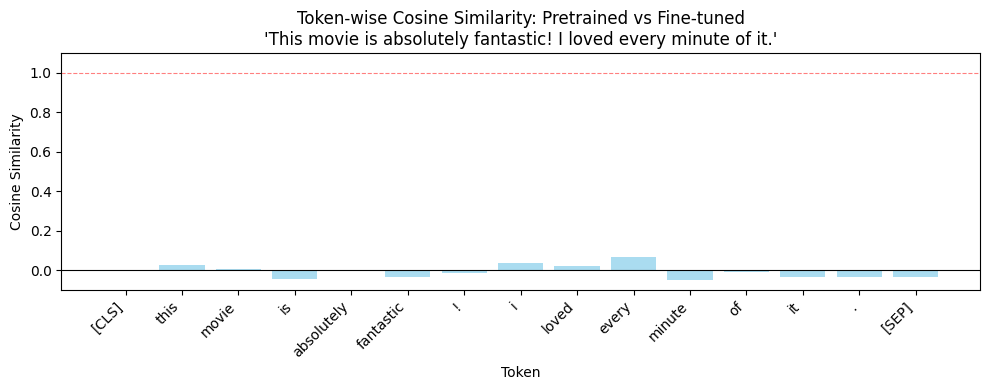

크게 변화한 토큰들 (유사도 < 0.9):
  minute: -0.0477
  is: -0.0460
  it: -0.0356
  .: -0.0317
  fantastic: -0.0316
  !: -0.0158
  of: -0.0082
  absolutely: 0.0029
  movie: 0.0057
  loved: 0.0221
  this: 0.0280
  i: 0.0383
  every: 0.0664

통계:
  평균 유사도: -0.0061
  최소 유사도: -0.0477
  최대 유사도: 0.0664
  변화한 토큰 수 (< 0.9): 15

==================== 문장 2 ====================
문장: The film was terrible and boring. I hated it.
------------------------------------------------------------


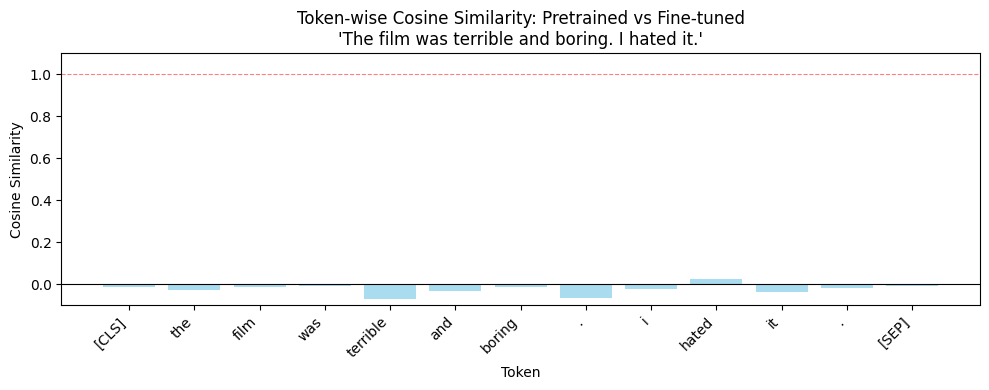

크게 변화한 토큰들 (유사도 < 0.9):
  terrible: -0.0694
  .: -0.0639
  it: -0.0371
  and: -0.0303
  the: -0.0286
  i: -0.0243
  .: -0.0190
  boring: -0.0153
  film: -0.0139
  was: -0.0105
  hated: 0.0268

통계:
  평균 유사도: -0.0235
  최소 유사도: -0.0694
  최대 유사도: 0.0268
  변화한 토큰 수 (< 0.9): 13

==================== 문장 3 ====================
문장: The movie was okay, nothing special but not bad either.
------------------------------------------------------------


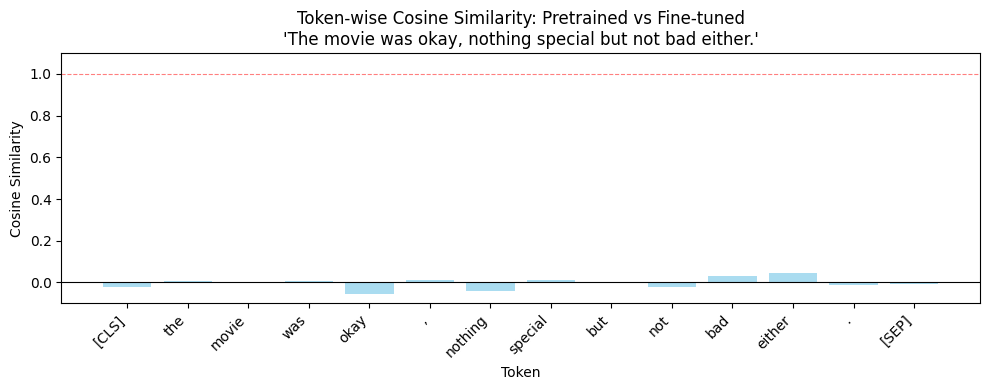

크게 변화한 토큰들 (유사도 < 0.9):
  okay: -0.0546
  nothing: -0.0409
  not: -0.0214
  .: -0.0103
  movie: -0.0030
  but: 0.0016
  was: 0.0079
  the: 0.0093
  ,: 0.0119
  special: 0.0122
  bad: 0.0295
  either: 0.0476

통계:
  평균 유사도: -0.0029
  최소 유사도: -0.0546
  최대 유사도: 0.0476
  변화한 토큰 수 (< 0.9): 14

==================== 전체 요약 ====================
전체 평균 유사도: -0.0104
전체 최소 유사도: -0.0694
전체 변화한 토큰 비율: 100.00%


In [132]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def extract_embeddings(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    # 배치 차원 제거: [0]을 추가
    last_hidden_state = outputs.hidden_states[-1][0]  # (seq_len, hidden_dim)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])  # [0] 추가
    return tokens, last_hidden_state

def compare_embeddings(model1, model2, tokenizer, text, model1_name="Pretrained", model2_name="Fine-tuned"):
    tokens, emb1 = extract_embeddings(model1, tokenizer, text)
    _, emb2 = extract_embeddings(model2, tokenizer, text)
    
    similarities = []
    for i in range(len(tokens)):
        # 코사인 유사도 계산 수정
        sim = cosine_similarity(emb1[i].unsqueeze(0).cpu().numpy(), 
                              emb2[i].unsqueeze(0).cpu().numpy())[0][0]
        similarities.append(sim)
    
    # 시각화
    plt.figure(figsize=(10, 4))
    bars = plt.bar(range(len(tokens)), similarities, color='skyblue', alpha=0.7)
    plt.axhline(y=0.0, color='black', linestyle='-', linewidth=0.8)
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
    
    # x축 레이블 설정
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
    plt.title(f"Token-wise Cosine Similarity: {model1_name} vs {model2_name}\n'{text}'")
    plt.ylabel("Cosine Similarity")
    plt.xlabel("Token")
    
    plt.ylim(-0.1, 1.1)
    plt.tight_layout()
    plt.show()
    
    # 변화가 큰 토큰들 출력
    changed_tokens = [(tokens[i], similarities[i]) for i in range(len(tokens)) 
                     if similarities[i] < 0.9 and tokens[i] not in ['[CLS]', '[SEP]', '[PAD]']]
    
    if changed_tokens:
        print(f"크게 변화한 토큰들 (유사도 < 0.9):")
        for token, sim in sorted(changed_tokens, key=lambda x: x[1]):
            print(f"  {token}: {sim:.4f}")
    else:
        print("크게 변화한 토큰이 없습니다.")
    
    return similarities

# 테스트 문장들
test_sentences = [
    "This movie is absolutely fantastic! I loved every minute of it.",
    "The film was terrible and boring. I hated it.",
    "The movie was okay, nothing special but not bad either.",
]

print("="*80)
print("토큰별 임베딩 유사도 분석 (사전훈련 vs 파인튜닝)")
print("="*80)

all_similarities = []
for i, sentence in enumerate(test_sentences):
    print(f"\n{'='*20} 문장 {i+1} {'='*20}")
    print(f"문장: {sentence}")
    print("-" * 60)
    
    similarities = compare_embeddings(pretrained_bert, classification_model, tokenizer, sentence)
    all_similarities.append(similarities)
    
    # 통계 정보 출력
    avg_sim = sum(similarities) / len(similarities)
    min_sim = min(similarities)
    max_sim = max(similarities)
    
    print(f"\n통계:")
    print(f"  평균 유사도: {avg_sim:.4f}")
    print(f"  최소 유사도: {min_sim:.4f}")
    print(f"  최대 유사도: {max_sim:.4f}")
    print(f"  변화한 토큰 수 (< 0.9): {sum(1 for s in similarities if s < 0.9)}")

# 전체 요약
print(f"\n{'='*20} 전체 요약 {'='*20}")
all_sims_flat = [sim for sims in all_similarities for sim in sims]
print(f"전체 평균 유사도: {sum(all_sims_flat) / len(all_sims_flat):.4f}")
print(f"전체 최소 유사도: {min(all_sims_flat):.4f}")
print(f"전체 변화한 토큰 비율: {sum(1 for s in all_sims_flat if s < 0.9) / len(all_sims_flat):.2%}")


In [122]:
# comparison_results에서 pretrained_analysis와 finetuned_analysis 내용 출력

def print_analysis_details(comparison_results):
    """comparison_results의 분석 내용을 상세히 출력"""
    
    if not comparison_results:
        print("comparison_results가 비어있습니다.")
        return
    
    for i, result in enumerate(comparison_results):
        print(f"\n{'='*60}")
        print(f"문장 {i+1}: {result.get('sentence', 'N/A')}")
        print('='*60)
        
        # Pretrained Analysis 출력
        print("\n[Pretrained Analysis]")
        print("-" * 30)
        pretrained_analysis = result['pretrained']
        
        print(f"Tokens: {pretrained_analysis['tokens']}")
        print(f"Attention Matrix Shape: {len(pretrained_analysis['avg_attention'])}x{len(pretrained_analysis['avg_attention'][0])}")
        print("Attention Matrix:")
        for j, row in enumerate(pretrained_analysis['avg_attention']):
            print(f"  {pretrained_analysis['tokens'][j]:>8}: {[f'{val:.3f}' for val in row]}")
        
        print("\nTarget Word Attention:")
        for token, attention_info in pretrained_analysis['target_word_attention'].items():
            print(f"  {token}: incoming={attention_info['incoming']:.4f}, outgoing={attention_info['outgoing']:.4f}")
        
        # Finetuned Analysis 출력
        print("\n[Fine-tuned Analysis]")
        print("-" * 30)
        finetuned_analysis = result['finetuned']
        
        print(f"Tokens: {finetuned_analysis['tokens']}")
        print(f"Attention Matrix Shape: {len(finetuned_analysis['avg_attention'])}x{len(finetuned_analysis['avg_attention'][0])}")
        print("Attention Matrix:")
        for j, row in enumerate(finetuned_analysis['avg_attention']):
            print(f"  {finetuned_analysis['tokens'][j]:>8}: {[f'{val:.3f}' for val in row]}")
        
        print("\nTarget Word Attention:")
        for token, attention_info in finetuned_analysis['target_word_attention'].items():
            print(f"  {token}: incoming={attention_info['incoming']:.4f}, outgoing={attention_info['outgoing']:.4f}")
        
        # 변화량 계산 및 출력
        print("\n[변화량 분석]")
        print("-" * 30)
        for token in pretrained_analysis['target_word_attention']:
            if token in finetuned_analysis['target_word_attention']:
                pre_incoming = pretrained_analysis['target_word_attention'][token]['incoming']
                fine_incoming = finetuned_analysis['target_word_attention'][token]['incoming']
                change = fine_incoming - pre_incoming
                print(f"  {token} incoming 변화: {pre_incoming:.4f} → {fine_incoming:.4f} (변화량: {change:+.4f})")

# 실행
print_analysis_details(comparison_results)



문장 1: This movie is absolutely fantastic! I loved every minute of it.

[Pretrained Analysis]
------------------------------
Tokens: ['[CLS]', 'this', 'movie', 'is', 'absolutely', 'fantastic', '!', 'i', 'loved', 'every', 'minute', 'of', 'it', '.', '[SEP]']
Attention Matrix Shape: 15x15
Attention Matrix:
     [CLS]: ['0.065', '0.073', '0.061', '0.064', '0.070', '0.059', '0.069', '0.068', '0.072', '0.066', '0.061', '0.065', '0.068', '0.072', '0.068']
      this: ['0.070', '0.066', '0.061', '0.068', '0.067', '0.056', '0.068', '0.068', '0.072', '0.066', '0.065', '0.069', '0.065', '0.068', '0.069']
     movie: ['0.065', '0.072', '0.061', '0.069', '0.065', '0.065', '0.066', '0.068', '0.071', '0.061', '0.063', '0.066', '0.066', '0.071', '0.070']
        is: ['0.069', '0.070', '0.059', '0.065', '0.071', '0.064', '0.068', '0.066', '0.070', '0.064', '0.065', '0.065', '0.067', '0.071', '0.066']
  absolutely: ['0.066', '0.069', '0.063', '0.066', '0.069', '0.062', '0.070', '0.070', '0.066', '0.064'